In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pandas as pd
import time

In [31]:
from google.colab import files
uploaded = files.upload()

Saving A2Q1.csv to A2Q1 (1).csv


# **Question 1**

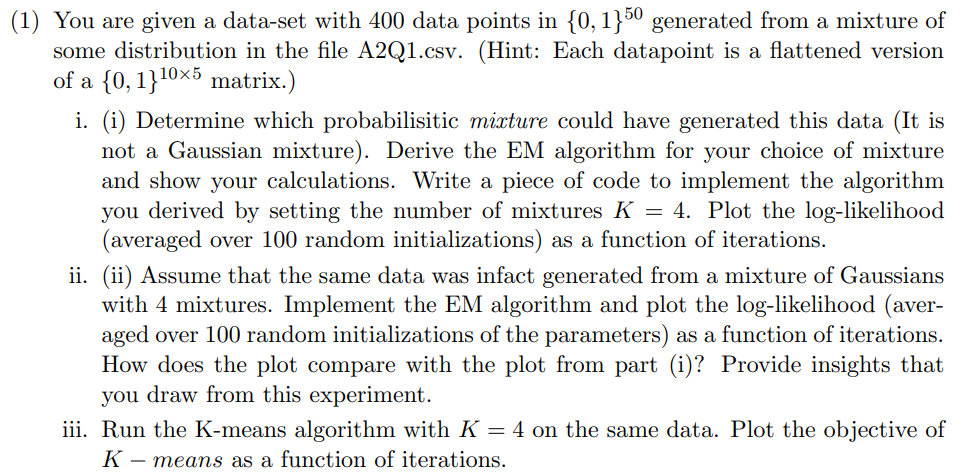

## **1. Expectation Maximisation Algorithms**

## Bernoulli Mixture Models

In [32]:
def BernoulliIterator(D,K,N,mu_bernoulli,Pi_bernoulli,df):
  Epsilon = 1e-10
  likelihoods_bernoulli = np.zeros((N, K))
  for i in range(K):
    likelihoods_bernoulli[:, i] = np.sum(df * np.log(mu_bernoulli[i] + Epsilon) + (1 - df) * np.log(1 - mu_bernoulli[i] + Epsilon), axis=1)
  weighted_likelihoods_bernoulli = likelihoods_bernoulli + np.log(Pi_bernoulli)
  lambd_bernoulli = np.exp(weighted_likelihoods_bernoulli - np.max(weighted_likelihoods_bernoulli, axis=1)[:, np.newaxis])
  lambd_bernoulli /= np.sum(lambd_bernoulli, axis=1)[:, np.newaxis]
  log_likelihood_bernoulli = np.sum(weighted_likelihoods_bernoulli)
  return Pi_bernoulli,mu_bernoulli,lambd_bernoulli,log_likelihood_bernoulli

In [33]:
def BernoulliIterator2(D,K,N,lambd_bernoulli,df):
  Pi_bernoulli = np.sum(lambd_bernoulli, axis=0) / N
  mu_bernoulli = np.dot(lambd_bernoulli.T,df) / np.sum(lambd_bernoulli, axis = 0)[:, np.newaxis]
  return Pi_bernoulli,mu_bernoulli,lambd_bernoulli

In [34]:
def RandomBernoulliVariables(N,D,K):
  Pi_bernoulli = np.random.rand(K)
  Pi_bernoulli = Pi_bernoulli / np.sum(Pi_bernoulli)
  mu_bernoulli = np.random.rand(K, D)
  lambd_bernoulli = np.random.rand(N, K)
  row_sums = lambd_bernoulli.sum(axis=1)
  lambd_bernoulli = lambd_bernoulli / row_sums[:, np.newaxis]
  return Pi_bernoulli, mu_bernoulli, lambd_bernoulli

In [35]:
def Bernoulli_Algorithm(N,D,K,no_of_epochs,df,tol,no_of_initialisations):
  log_like_bernoulli = np.empty((no_of_initialisations,no_of_epochs))
  for t in range(no_of_initialisations):
    prev_log_likelihood_bernoulli = -np.inf
    Pi_bernoulli, mu_bernoulli, lambd_bernoulli = RandomBernoulliVariables(N,D,K)
    for epoch in range(no_of_epochs):
      Pi_bernoulli,mu_bernoulli,lambd_bernoulli,log_likelihood = BernoulliIterator(D,K,N,mu_bernoulli,Pi_bernoulli,df)
      Pi_bernoulli,mu_bernoulli,lambd_bernoulli = BernoulliIterator2(D,K,N,lambd_bernoulli,df)
      if log_likelihood >= prev_log_likelihood_bernoulli:
        log_like_bernoulli[t][epoch] = log_likelihood
      else :
        break
  mean_log_like_bernoulli = np.nanmean(log_like_bernoulli, axis = 0)
  print(mean_log_like_bernoulli)
  return mean_log_like_bernoulli

In [36]:
df = pd.read_csv('A2Q1.csv')
N = df.shape[0]
D = df.shape[1]
K = 4
no_of_epochs = 8
tolerance = 1e-6        # Setting max error
no_of_initialisations = 100
N,D

(399, 50)

In [37]:
mean_log_like_bernoulli = Bernoulli_Algorithm(N,D,K,no_of_epochs,df,tolerance,no_of_initialisations)

[-82067.80222419 -42709.65311479 -52831.47534691 -64050.25099231
 -71641.08654335 -77099.63528571 -80575.23756963 -82970.84655691]


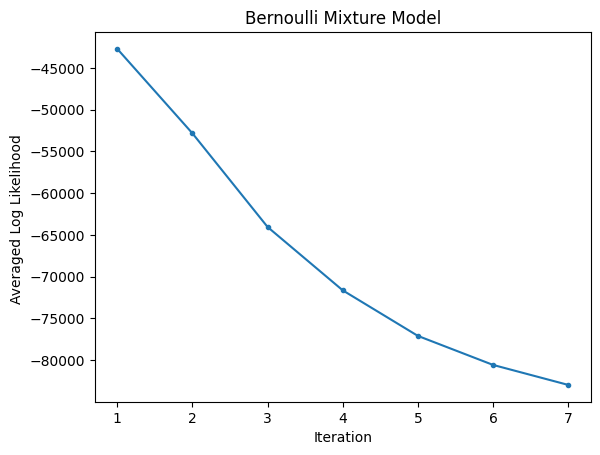

In [38]:
plt.plot(range(1, len(mean_log_like_bernoulli) ), mean_log_like_bernoulli[1:len(mean_log_like_bernoulli)], marker='.')
plt.xlabel('Iteration')
plt.ylabel('Averaged Log Likelihood ')
plt.title('Bernoulli Mixture Model')
plt.show()

## Gaussian Mixture Models

In [39]:
def Initialisation_Gaussian(N,D,K,df):
  Pi_gaus = np.random.rand(K)
  Pi_gaus = Pi_gaus / np.sum(Pi_gaus)
  mu_gaus = np.random.rand(K, D)
  sigma_gaus = np.random.rand(K, D)
  lambd_gaus = np.random.rand(N, K)
  row_sums = lambd_gaus.sum(axis=1)
  lambd_gaus = lambd_gaus / row_sums[:, np.newaxis]
  return Pi_gaus, mu_gaus, sigma_gaus, lambd_gaus

In [40]:
def expectation_gaussians(D, K, N, mu_gaus, sigma_gaus, Pi_gaus, lambd_gaus, df):
    Epsilon = 1e-10
    likelihoods = np.zeros((N, K))
    for i in range(K):
        for j in range(N):
            mahalanobis_dist = 0
            for d in range(D):
                mahalanobis_dist += (df.iloc[j,d] - mu_gaus[i][d]) ** 2 / (2 * sigma_gaus[i][d] + Epsilon)


            # The log likelihood using the Mahalanobis distance
            likelihoods[j, i] = -0.5 * (D * np.log(2 * np.pi * np.prod(sigma_gaus[i]) + Epsilon)) + mahalanobis_dist
    weighted_likelihoods = likelihoods + np.log(Pi_gaus + Epsilon)
    log_likelihood = np.sum(weighted_likelihoods)
    lambd_gaus = np.exp(weighted_likelihoods - np.max(weighted_likelihoods, axis=1)[:, np.newaxis])
    lambd_gaus /= np.sum(lambd_gaus, axis=1)[:, np.newaxis]
    lambd_gaus = np.nan_to_num(lambd_gaus, nan = 0)

    return Pi_gaus, mu_gaus, lambd_gaus, log_likelihood

In [41]:
def maximization_gaussian(D, K, N, mu_gaus, sigma_gaus, lambd_gaus, df):
    Epsilon = 1e-10
    Nk = np.sum(lambd_gaus, axis=0)
    Pi_gaus = Nk / N
    kaka = np.dot(lambd_gaus.T, df)
    mu_gaus = np.dot(lambd_gaus.T, df) / (Nk[:, np.newaxis] + Epsilon)
    for k in range(K):
      sigma_gaus[k] = np.sum(lambd_gaus[:, k] * np.sum((df - mu_gaus[k])**2, axis=1)) / ( Nk[k] + Epsilon)  # Changed calculation of sigma_gaus
    return Pi_gaus, mu_gaus, sigma_gaus

In [42]:
def EM_Gaussian_Algorithm(N,D,K,no_of_epochs,df,tol,no_of_initialisations):
  prev_log_likelihood = -np.inf
  log_like = np.empty((no_of_initialisations,no_of_epochs))
  for t in range(no_of_initialisations):
    Pi_gaus, mu_gaus, sigma_gaus, lambd_gaus = Initialisation_Gaussian(N,D,K,df)
    for epoch in range(no_of_epochs):
      Pi_gaus,mu_gaus,lambd_gaus,log_likelihood = expectation_gaussians(D, K, N, mu_gaus, sigma_gaus, Pi_gaus, lambd_gaus, df)
      Pi_gaus,mu_gaus,lambd_gaus = maximization_gaussian(D, K, N, mu_gaus, sigma_gaus, lambd_gaus, df)
      log_like[t][epoch] = log_likelihood
      prev_log_likelihood = log_likelihood
  mean_log_like_gaus = np.nanmean(log_like, axis = 0)
  return mean_log_like_gaus,mu_gaus, sigma_gaus, lambd_gaus, Pi_gaus

In [137]:
df = pd.read_csv('A2Q1.csv')
N = df.shape[0]
D = df.shape[1]
K = 4
no_of_epochs = 4
tolerance = 1e-6
no_of_initialisations = 100
mean_log_like,mu_gaus,sigma_gaus,lambd_gaus,Pi_gaus = EM_Gaussian_Algorithm(N,D,K,no_of_epochs,df,tolerance,no_of_initialisations)

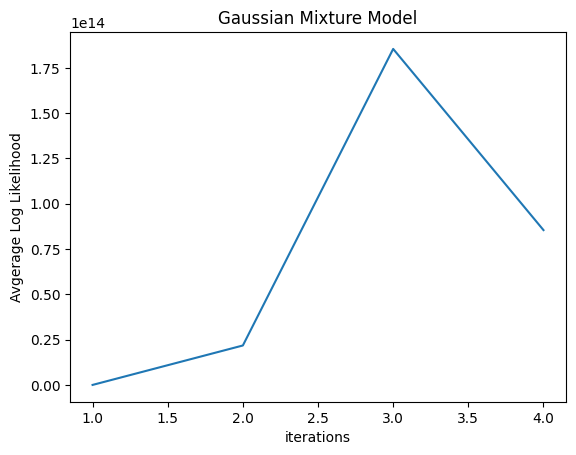

In [139]:
plt.plot(range(1, len(mean_log_like) + 1), mean_log_like)
plt.xlabel('iterations')
plt.ylabel('Avgerage Log Likelihood')
plt.title('Gaussian Mixture Model')
plt.show()

## K Means Clustering

In [101]:
def euclidean_distance(x1, x2):
  distance = np.sqrt(np.sum((x1 - x2) ** 2))
  return distance

In [100]:
#Initializing with Random values
def initialize_centroids(df, K):
  random_indices = np.random.choice(df.shape[0], size=K, replace=False)
  centroids_initial = df[random_indices]
  return centroids_initial

In [99]:
# Assign each data point to the nearest centroid
def clusterIdentifier(df, centroids):
  clusters = []

  for data_point in df:
    distances = [euclidean_distance(data_point, centroid) for centroid in centroids]
    cluster_distances = np.argmin(distances)
    clusters.append(cluster_distances)

  return np.array(clusters)

In [98]:
# new means for the clusters
def newMeans(df, clusters, K):
  centroids = np.zeros((K, df.shape[1]))

  for cluster in range(K):
    cluster_points = df[clusters == cluster]

    if len(cluster_points) > 0:
      centroids[cluster] = np.mean(cluster_points, axis=0)

  return centroids

In [97]:
# Objective Function
def error(data, centroids, clusters):
  objective = 0

  for i, centroid in enumerate(centroids):
    cluster_points = data[clusters == i]

    if len(cluster_points) > 0:
      objective += np.sum((cluster_points - centroid) ** 2)

  return objective

In [126]:
def Kmeans(data, k, max_iter):

  centroids = initialize_centroids(data, k)
  errs = []                                 # Objectives for each iteration
  centroid_history = [centroids]

  for iter in range(max_iter):
    clusters = clusterIdentifier(data, centroids)
    new_centroids = newMeans(data, clusters, k)
    objective = error(data, new_centroids, clusters)
    errs.append(objective)

    if np.allclose(new_centroids, centroids):
      break

    centroids = new_centroids
    centroid_history.append(centroids)

  return clusters, centroids, errs, centroid_history

In [132]:
K = 4
df = pd.read_csv('A2Q1.csv')
N = df.shape[0]
D = df.shape[1]
data = df.values
max_iter = 500

clusters, centroids, errs, centroid_history = Kmeans(data, K, max_iter)
print(errs)

[2218.376663784021, 2178.6300101471334, 1983.401461492841, 1754.3724009010446, 1742.8341061377648, 1739.2729630782853, 1736.179526977088, 1736.179526977088]


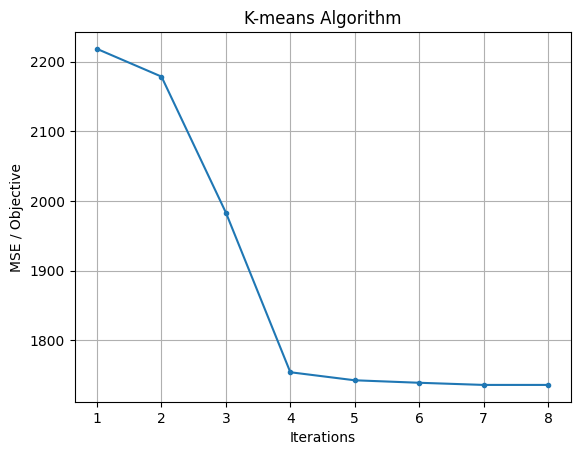

In [136]:
plt.plot(range(1, len(errs) + 1), errs, marker = '.')
plt.xlabel('Iterations')
plt.ylabel('MSE / Objective')
plt.title('K-means Algorithm')
plt.grid(True)
plt.show()

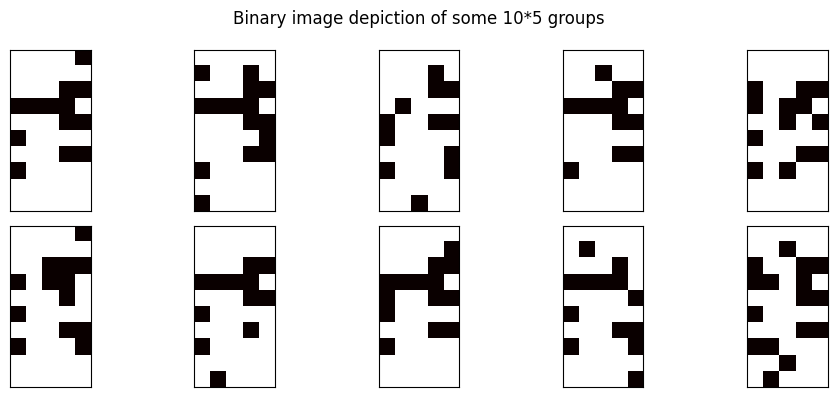

In [70]:
def plot_data_points(data,n):
    num_rows = int(np.ceil(n / 5))
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 2*num_rows))
    fig.suptitle('Binary image depiction of some 10*5 groups')
    for i, ax in enumerate(axes.flatten()):
        if i < 10:
            ax.imshow(data[i].reshape(10, 5), cmap='hot_r', vmin=0, vmax=1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xticklabels([])
            ax.set_yticklabels([])

    plt.tight_layout()
    plt.show()

plot_data_points(data,10)
